# Tutorial of SPOTS data

## Load the required packages

This notebook should be placed in the same directory as the **COSIE** folder.

In [1]:
import os
import torch
import scanpy as sc
import importlib
import numpy as np

In [2]:
from COSIE.data_preprocessing import load_data
from COSIE.utils import setup_seed
from COSIE.configure import get_default_config
from COSIE.COSIE_framework import COSIE_model
from COSIE.downstream_analysis import *


config = get_default_config()
setup_seed(config['training']['seed'])

## Load Data

The input data for this tutorial can be downloaded from: 

https://drive.google.com/drive/folders/16svIq_q4ZefGD6GhsD0-eenU-W-eu8tO?usp=sharing

After downloading, data should be placed into a new folder named `SPOTS` in the current working directory.


In [3]:
file_path = './SPOTS'

In [4]:
adata1_rna = sc.read_h5ad(os.path.join(file_path, 'adata_section1_rna.h5ad'))
adata1_adt = sc.read_h5ad(os.path.join(file_path, 'adata_section1_adt.h5ad'))
adata2_rna = sc.read_h5ad(os.path.join(file_path, 'adata_section2_rna.h5ad'))
adata2_adt = sc.read_h5ad(os.path.join(file_path, 'adata_section2_adt.h5ad'))


In [5]:
adata1_rna.var_names_make_unique()
adata1_adt.var_names_make_unique()
adata2_rna.var_names_make_unique()
adata2_adt.var_names_make_unique()


In [7]:
adata1_rna, adata1_adt, adata2_rna, adata2_adt

(AnnData object with n_obs × n_vars = 2568 × 32285
     var: 'gene_ids', 'feature_types', 'genome'
     obsm: 'spatial',
 AnnData object with n_obs × n_vars = 2568 × 21
     obsm: 'spatial',
 AnnData object with n_obs × n_vars = 2759 × 32285
     obsm: 'location1', 'location2', 'spatial',
 AnnData object with n_obs × n_vars = 2759 × 21
     obsm: 'location1', 'location2', 'spatial')

## Define the dictionary structure for input data


- `data_dict` is a Python dictionary that maps each modality name (e.g., `'RNA'`, `'Protein'`) to a list of `AnnData` objects, where:

    - Each element in the list represents one tissue section.
    - Each `AnnData` must include:
      - `.X` — expression or intensity matrix  
      - `.obs` — per-cell obs data  
      - `.var` — per-feature var data  
      - `.obsm['spatial']` — spatial coordinates  
    - If a modality is missing in a section, use `None` as a placeholder.


Here we pretend **Protein is missing in Section2**

In [8]:
data_dict = {
        'RNA': [adata1_rna, adata2_rna],
        'Protein': [adata1_adt, None],
    }

The constructed `data_dict` will be processed by `load_data` function, which returns processed feature matrices and spatial coordinates. 

`n_comps` is the number of PCA components to compute.

In [9]:
feature_dict, spatial_loc_dict, data_dict_processed = load_data(data_dict, n_comps=50)

-------- Processing shared modality RNA across sections --------


2025-06-10 16:45:27,612 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...


Running Harmony for RNA


2025-06-10 16:45:29,661 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-06-10 16:45:29,746 - harmonypy - INFO - Iteration 1 of 10
2025-06-10 16:45:31,525 - harmonypy - INFO - Iteration 2 of 10
2025-06-10 16:45:33,054 - harmonypy - INFO - Iteration 3 of 10
2025-06-10 16:45:34,511 - harmonypy - INFO - Iteration 4 of 10
2025-06-10 16:45:36,041 - harmonypy - INFO - Iteration 5 of 10
2025-06-10 16:45:37,417 - harmonypy - INFO - Iteration 6 of 10
2025-06-10 16:45:38,938 - harmonypy - INFO - Iteration 7 of 10
2025-06-10 16:45:39,793 - harmonypy - INFO - Iteration 8 of 10
2025-06-10 16:45:41,526 - harmonypy - INFO - Iteration 9 of 10
2025-06-10 16:45:42,270 - harmonypy - INFO - Iteration 10 of 10
2025-06-10 16:45:42,960 - harmonypy - INFO - Stopped before convergence


-------- Processing unique modality Protein for section 1 --------
Extracting spatial location for section 1
Extracting spatial location for section 2


## Specify the Linkage Indicator

COSIE requires an **indicator dictionary** to specify the cross-section linkage used during training. The following ```('s1', 's2'): [('RNA', 'RNA')]``` indicates that the RNA–RNA linkage between section s1 and s2 will be used as the cross-section linkage information.

In [11]:
Linkage_indicator = {
        ('s1', 's2'): [ ('RNA', 'RNA')]
    }

## Define COSIE model and perform integration

After training, embeddings will be saved to `file_path` in `.npy` format for each section independently.

In [12]:
model = COSIE_model(config, feature_dict)
optimizer = torch.optim.Adam(model.parameters(), lr=config['training']['lr'])
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

All modalities: ['RNA', 'Protein']
-------- Encoder description --------
Encoder [RNA]: Input 50 → Hidden [256, 128]
Encoder [Protein]: Input 20 → Hidden [256, 128]
-------- Dual prediction module description --------
Predictor [RNA → Protein]: [128, 512, 512, 128]
Predictor [Protein → RNA]: [128, 512, 512, 128]
Using device: cuda:0


In [13]:
final_embeddings = model.train_model(file_path, config, optimizer, device, feature_dict, spatial_loc_dict, 
                                     data_dict_processed, Linkage_indicator)

-------- Running Full-graph training mode --------
Computing linkage between RNA (s1) and RNA (s2)
Model moved to cuda:0!
-------- Construction of input graphs --------
-------- Constructing spatial graph for s1 --------
Constructing feature graph for [s1 - RNA]...
Constructing feature graph for [s1 - Protein]...
-------- Constructing spatial graph for s2 --------
Constructing feature graph for [s2 - RNA]...
Training started!


Training Epochs: 100%|████████████████████████████████████████████████████████████████| 600/600 [00:11<00:00, 52.06it/s]


Running Evaluation...
Missing modality [Protein] in Section [s2]
Using predictor [RNA → Protein] to recover missing embedding...
All embeddings have been saved to ../../../project/SpatialMultimodal/datasets/SPOTS


## Joint clustering and visualization

Joing tissue segmentation based on COSIE's embedding

Perform joint clustering...


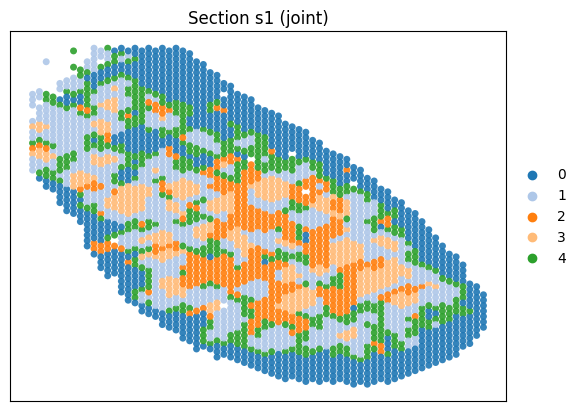

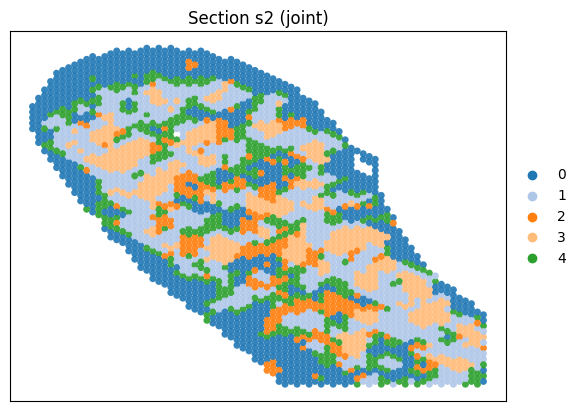

In [14]:
cluster_label = cluster_and_visualize(final_embeddings, 
                                     data_dict,
                                     n_clusters=5,
                                     mode="joint", 
                                     vis_basis="spatial",  
                                     s=100,
                                     dpi = 300,)

## Predict protein data for Section 2

COSIE recovers missing modality data for each section by leveraging feature similarity within its integrated embedding space.

Users can specify the **section** to be predicted, the **modality** to recover, the **target molecules**, and one or more **source sections** from which observed data will serve as the reference.

In [15]:
adata2_adt_predicted = perform_prediction(data_dict,
    final_embeddings,
    target_section = 's2',
    target_modality = 'Protein',
    K_num=50,
    target_molecules='All',
    )

Using modality [RNA] in section [s2] as spatial/obs reference
[Protein] exists in ['s1'], which will be used as source data section


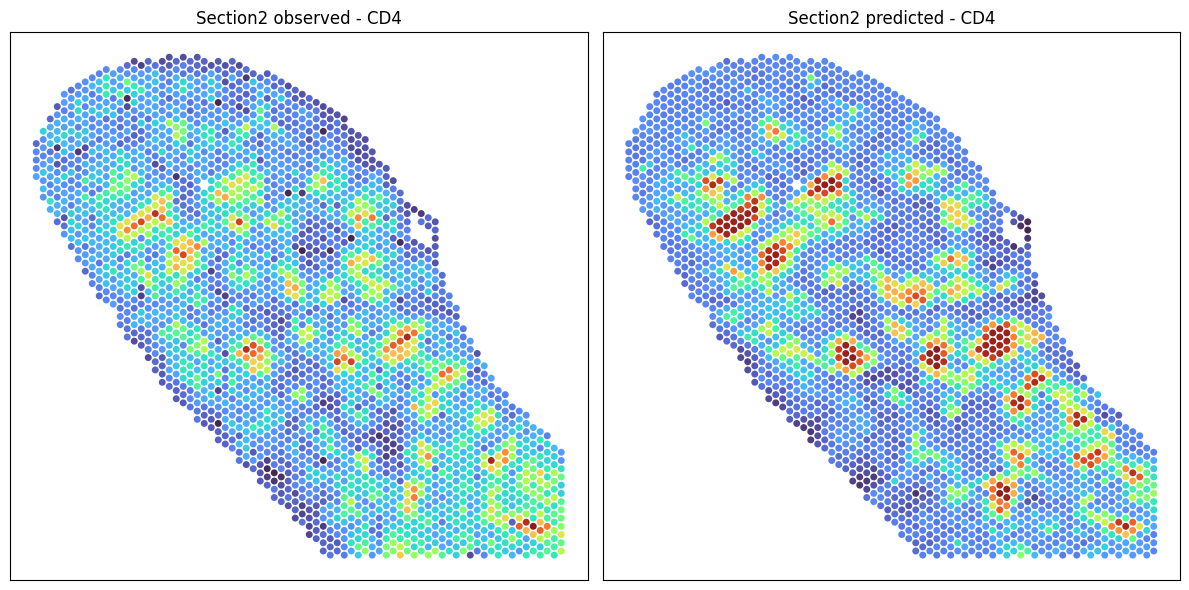

In [16]:
chosed_protein = 'CD4'
plot_marker_comparison(chosed_protein, 
                       adata2_adt, 
                       adata2_adt_predicted, 
                       section1_label = 'Section2 observed', 
                       section2_label = 'Section2 predicted', 
                       dpi = 200,
                       s=100)